# ProjectF

The initiation for this problem is at the image
segmentation stage where we have to identify from MRI
images. We will be using a basic Convolutional Neural
Network (CNN) as our baseline model and the proposed
model will be a variant of this.
1. Baseline: A CNN is an algorithm that primarily
rose to prominence because of its ability to take input images, assign weights and biases to different parts of the images and differentiate them
from one another. The data is trained by iterating through the training dataset multiple times and weighing the outputs or applying a bias on the neurons based on how close the output is to the expected output.
2. Proposed: We plan to use variants of CNN called
Fast R-CNN and Mask R-CNN. While a CNN is
adequate to classify the images, to determine the
location of an object, we need to use
segmentation and for that we need Mask R-CNN.
This Mask R-CNN is overlaid on a fast R-CNN
which basically uses the feature maps we get
from the images using normal CNN and then
passes it through a Region Proposal Network
(RPN) which creates boundaries and tries to
determine if an object is there in those
boundaries.

In [ ]:
import torch
import numpy as np

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

Using CPU


## Loading the Data

We load the data, transform it to be the in the correct format, and create the training, validation and test sets.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Percentage of training used for validation
valid_size = 0.2
batch_size = 20
data_dir = '/content/drive/MyDrive/Final_Project_ECE542/ProjectF/dataset'
  
#Do some preprocessing before using the image
# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
  #Resize the image 
  transforms.Resize((150, 150)),
  # Converting RGB [0,255] to Tensor [0,1]
  transforms.ToTensor(),
  # Normalizes using specified mean and std per channel
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 

  ])

train_set = datasets.ImageFolder(data_dir + '/Training', transform = transform)
test_set = datasets.ImageFolder(data_dir + '/Testing', transform = transform)

# Getting training indices that will be used for validation
num_train = len(train_set)
idx = list(range(num_train))
np.random.shuffle(idx)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = idx[split:], idx[:split]

# Defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Preparing data loader
train = DataLoader(train_set, batch_size = batch_size, sampler=train_sampler)
valid = DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler)
test = DataLoader(test_set, batch_size=batch_size)

# specify the image classes
classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'] # Defining the classes we have 
print(f'The classes are: {classes}')

The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


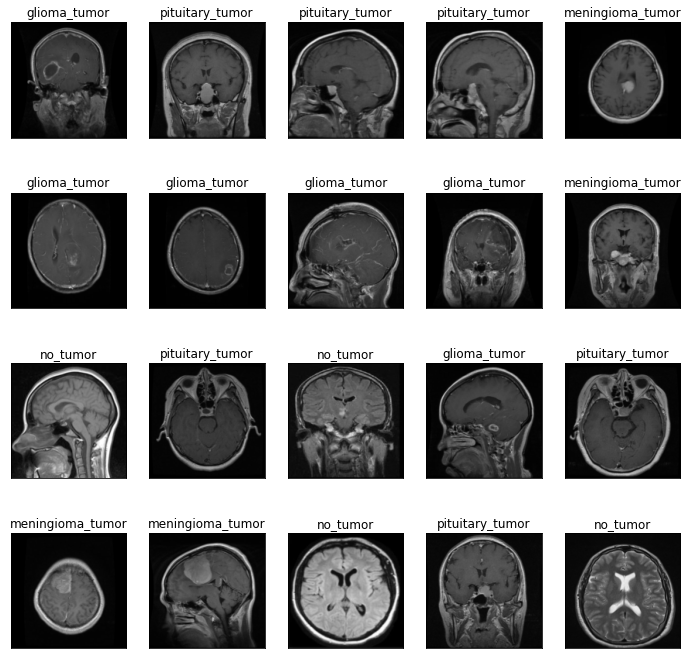

In [ ]:
import matplotlib.pyplot as plt

# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert from Tensor image

# Obtaining one batch of training images
dataiter = iter(train)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plotting the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 12))
for idx in np.arange(images.shape[0]):
  ax = fig.add_subplot(4,images.shape[0]/4, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

## Defining the Model and Optimizer

A class is created to specify the network structure.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchsummary import summary

# Defining the CNN architecture with batch normalization
# Helpful link: https://discuss.pytorch.org/t/valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498/5
#Helpful link: https://towardsdatascience.com/how-to-apply-a-cnn-from-pytorch-to-your-images-18515416bba1

class Net(nn.Module):
  def __init__(self, num_classes=4):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    self.bn_1 = nn.BatchNorm2d(num_features=12)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
    self.bn_2 = nn.BatchNorm2d(num_features=20)
    self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.bn_3 = nn.BatchNorm2d(num_features=32)
    self.fc1 = nn.Linear(in_features=32*18*18,out_features=16*18*18)
    self.fc2 = nn.Linear(in_features=16*18*18,out_features=8*18*18)
    self.fc3 = nn.Linear(in_features=8*18*18,out_features=num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.bn_1(self.conv1(x))))
    x = self.pool(F.relu(self.bn_2(self.conv2(x))))
    x = self.pool(F.relu(self.bn_3(self.conv3(x))))
    #print(x.shape)
    x = x.view(-1, 32*18*18) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Create a complete CNN
model = Net(num_classes=4)
print(model)

# Move tensors to GPU if CUDA is available
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify Adam optimizer
optimizer = optim.AdamW(model.parameters(), lr=.001)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10368, out_features=5184, bias=True)
  (fc2): Linear(in_features=5184, out_features=2592, bias=True)
  (fc3): Linear(in_features=2592, out_features=4, bias=True)
)


In [ ]:
#Summary of model 
summary(model, (3,150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
         MaxPool2d-3           [-1, 12, 75, 75]               0
            Conv2d-4           [-1, 20, 75, 75]           2,180
       BatchNorm2d-5           [-1, 20, 75, 75]              40
         MaxPool2d-6           [-1, 20, 37, 37]               0
            Conv2d-7           [-1, 32, 37, 37]           5,792
       BatchNorm2d-8           [-1, 32, 37, 37]              64
         MaxPool2d-9           [-1, 32, 18, 18]               0
           Linear-10                 [-1, 5184]      53,752,896
           Linear-11                 [-1, 2592]      13,439,520
           Linear-12                    [-1, 4]          10,372
Total params: 67,211,224
Trainable params: 67,211,224
Non-trainable params: 0
-------------------------

## Training the Model


In [ ]:
import matplotlib.pyplot as plt

# Specifying the number of epochs
n_epochs = 20

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):
  # Unpacking the number of epochs to train the model
  epochs_list = [*range(1,n_epochs+1)]

  # List to store loss to visualize
  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss

  for epoch in epochs_list:
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      
      ######################
      # Training the model #
      ######################
      model.train()
      for data, target in train:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          # Clearing the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: Computing predicted outputs
          output = model(data)
          # Calculating the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      ########################    
      # Validating the model #
      ########################
      model.eval()
      for data, target in valid:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/len(train_sampler)
      valid_loss = valid_loss/len(valid_sampler)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      # Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model_cifar.pt')
          valid_loss_min = valid_loss
        
  return epochs_list, train_losslist, valid_losslist

# Executing the training
epochs_list, train_losslist, valid_losslist = trainNet(
    model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model_cifar.pt'))

# Plotting the learning curves
plt.plot(epochs_list, train_losslist, epochs_list, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

KeyboardInterrupt: ignored

# Evaluating Performance

Here we use the test set for the final performance of the model. We define a helper function as well for ease of future evaluation of different models.


##Accuracy


In [ ]:
from sklearn.metrics import f1_score
def assessNet(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  # Setting model to evaluate
  model.eval()
  batch_size = 197
  test = DataLoader(test_set, batch_size = batch_size)

  # Iterating over batches of test data
  for data, target in test:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1)
    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      
      # Calculating test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(test.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))


  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  return

# Executing the assessment
assessNet(model,criterion)

Test Loss: 3.137608

Test Accuracy of glioma_tumor: 13% (13/100)
Test Accuracy of meningioma_tumor: 71% (82/115)
Test Accuracy of   no_tumor: 97% (102/105)
Test Accuracy of pituitary_tumor: 67% (50/74)

Test Accuracy (Overall): 62% (247/394)


## Precision, Recall, F1 Score


In [ ]:
from sklearn.metrics import f1_score

#F1_score = 2*(precision*recall)/(precision+recall)

# Fast R-CNN

Implement Fast R-CNN

In [ ]:
import torchvision

model2 = torchvision.models.vgg16(pretrained=True).to(device)
fc2 = list(model2.features)
print(len(fc2))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

31


In [ ]:
from sklearn import preprocessing
from torch.nn.functional import normalize

#Prediction Function
def predict(classes, data, target, model):
  output = model(data) # get the predictions on the image

  pred_score, pred = torch.max(output, 1)
  amount = torch.max(pred_score)
  pred_class = [classes[i] for i in list(pred.cpu().numpy())]
  pred_class = [ for i in list(pred_score.cpu().numpy())]

      
  print(amount)
  #print(pred_class)
  return pred_class, pred_score

#Different color for each class 
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Setting model to evaluate
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

#Test data 
batch_size = 197
test = DataLoader(test_set, batch_size = batch_size)

# Iterating over batches of test data
for data, target in test:
  if flag_cuda:
    data, target = data.cuda(), target.cuda()
  pred_class, pred_score = predict(classes, data, target, model)
  


tensor(13.9813, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(16.2438, device='cuda:0', grad_fn=<MaxBackward1>)
